This file is ANOM for industries comparison

First, we import some necessary libraries

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
number_group = 11
np.random.seed(1)

We read data of 11 industries and use 5 attributes since they have larger size and better distribution.

In [203]:
df = pd.read_csv("data2/real_estate.csv")
c = df.values[:,0]
v = df.values[:, 1:].T
df = pd.DataFrame(data = v, columns = c)
df = df[["priceToEarning", "priceToBook","roe","debtOnEquity","rsi"]]
df["group"] = 1


i = 2
group_dict = {1: "real_estate"}
for g in ["mineral", "production", "retail", "Technology", "tourism", "transportation","chemistry"]:
    dd = pd.read_excel("data2/" + g + ".xlsx")
    c = dd.values[:,0]
    v = dd.values[:, 1:].T
    dd = pd.DataFrame(data = v, columns = c)
    dd = dd[["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]]
    dd["group"] = i
    group_dict[i] = g
    df = pd.concat([df,dd])
    i+=1
for g in ["security","Drink_food", "Bank_ind"]:
    dd = pd.read_csv("data2/" + g + ".csv")
    c = dd.values[:,0]
    v = dd.values[:, 1:].T
    dd = pd.DataFrame(data = v, columns = c)
    dd = dd[["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]]
    dd["group"] = i
    group_dict[i] = g
    df = pd.concat([df,dd])
    i+=1
group_dict

{1: 'real_estate',
 2: 'mineral',
 3: 'production',
 4: 'retail',
 5: 'Technology',
 6: 'tourism',
 7: 'transportation',
 8: 'chemistry',
 9: 'security',
 10: 'Drink_food',
 11: 'Bank_ind'}

In [204]:
df[["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]] = df[["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]].apply(pd.to_numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 19
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   priceToEarning  180 non-null    float64
 1   priceToBook     180 non-null    float64
 2   roe             180 non-null    float64
 3   debtOnEquity    180 non-null    float64
 4   rsi             180 non-null    float64
 5   group           180 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 9.8 KB


In [208]:
df.head()

,priceToEarning,priceToBook,roe,debtOnEquity,rsi,group
0,36.6,0.8,0.022,1.4,57.2,1
1,6.8,1.6,0.251,0.2,58.9,1
2,28.1,1.8,0.065,1.4,47.1,1
3,65.9,4.9,0.076,0.9,54.7,1
4,18.8,1.8,0.103,0.1,60.6,1


In [209]:
lis_group= []

for i in range(1,number_group+1):
  lis_group.append(df.loc[df["group"] == i].drop(["group"],axis = 1))
  

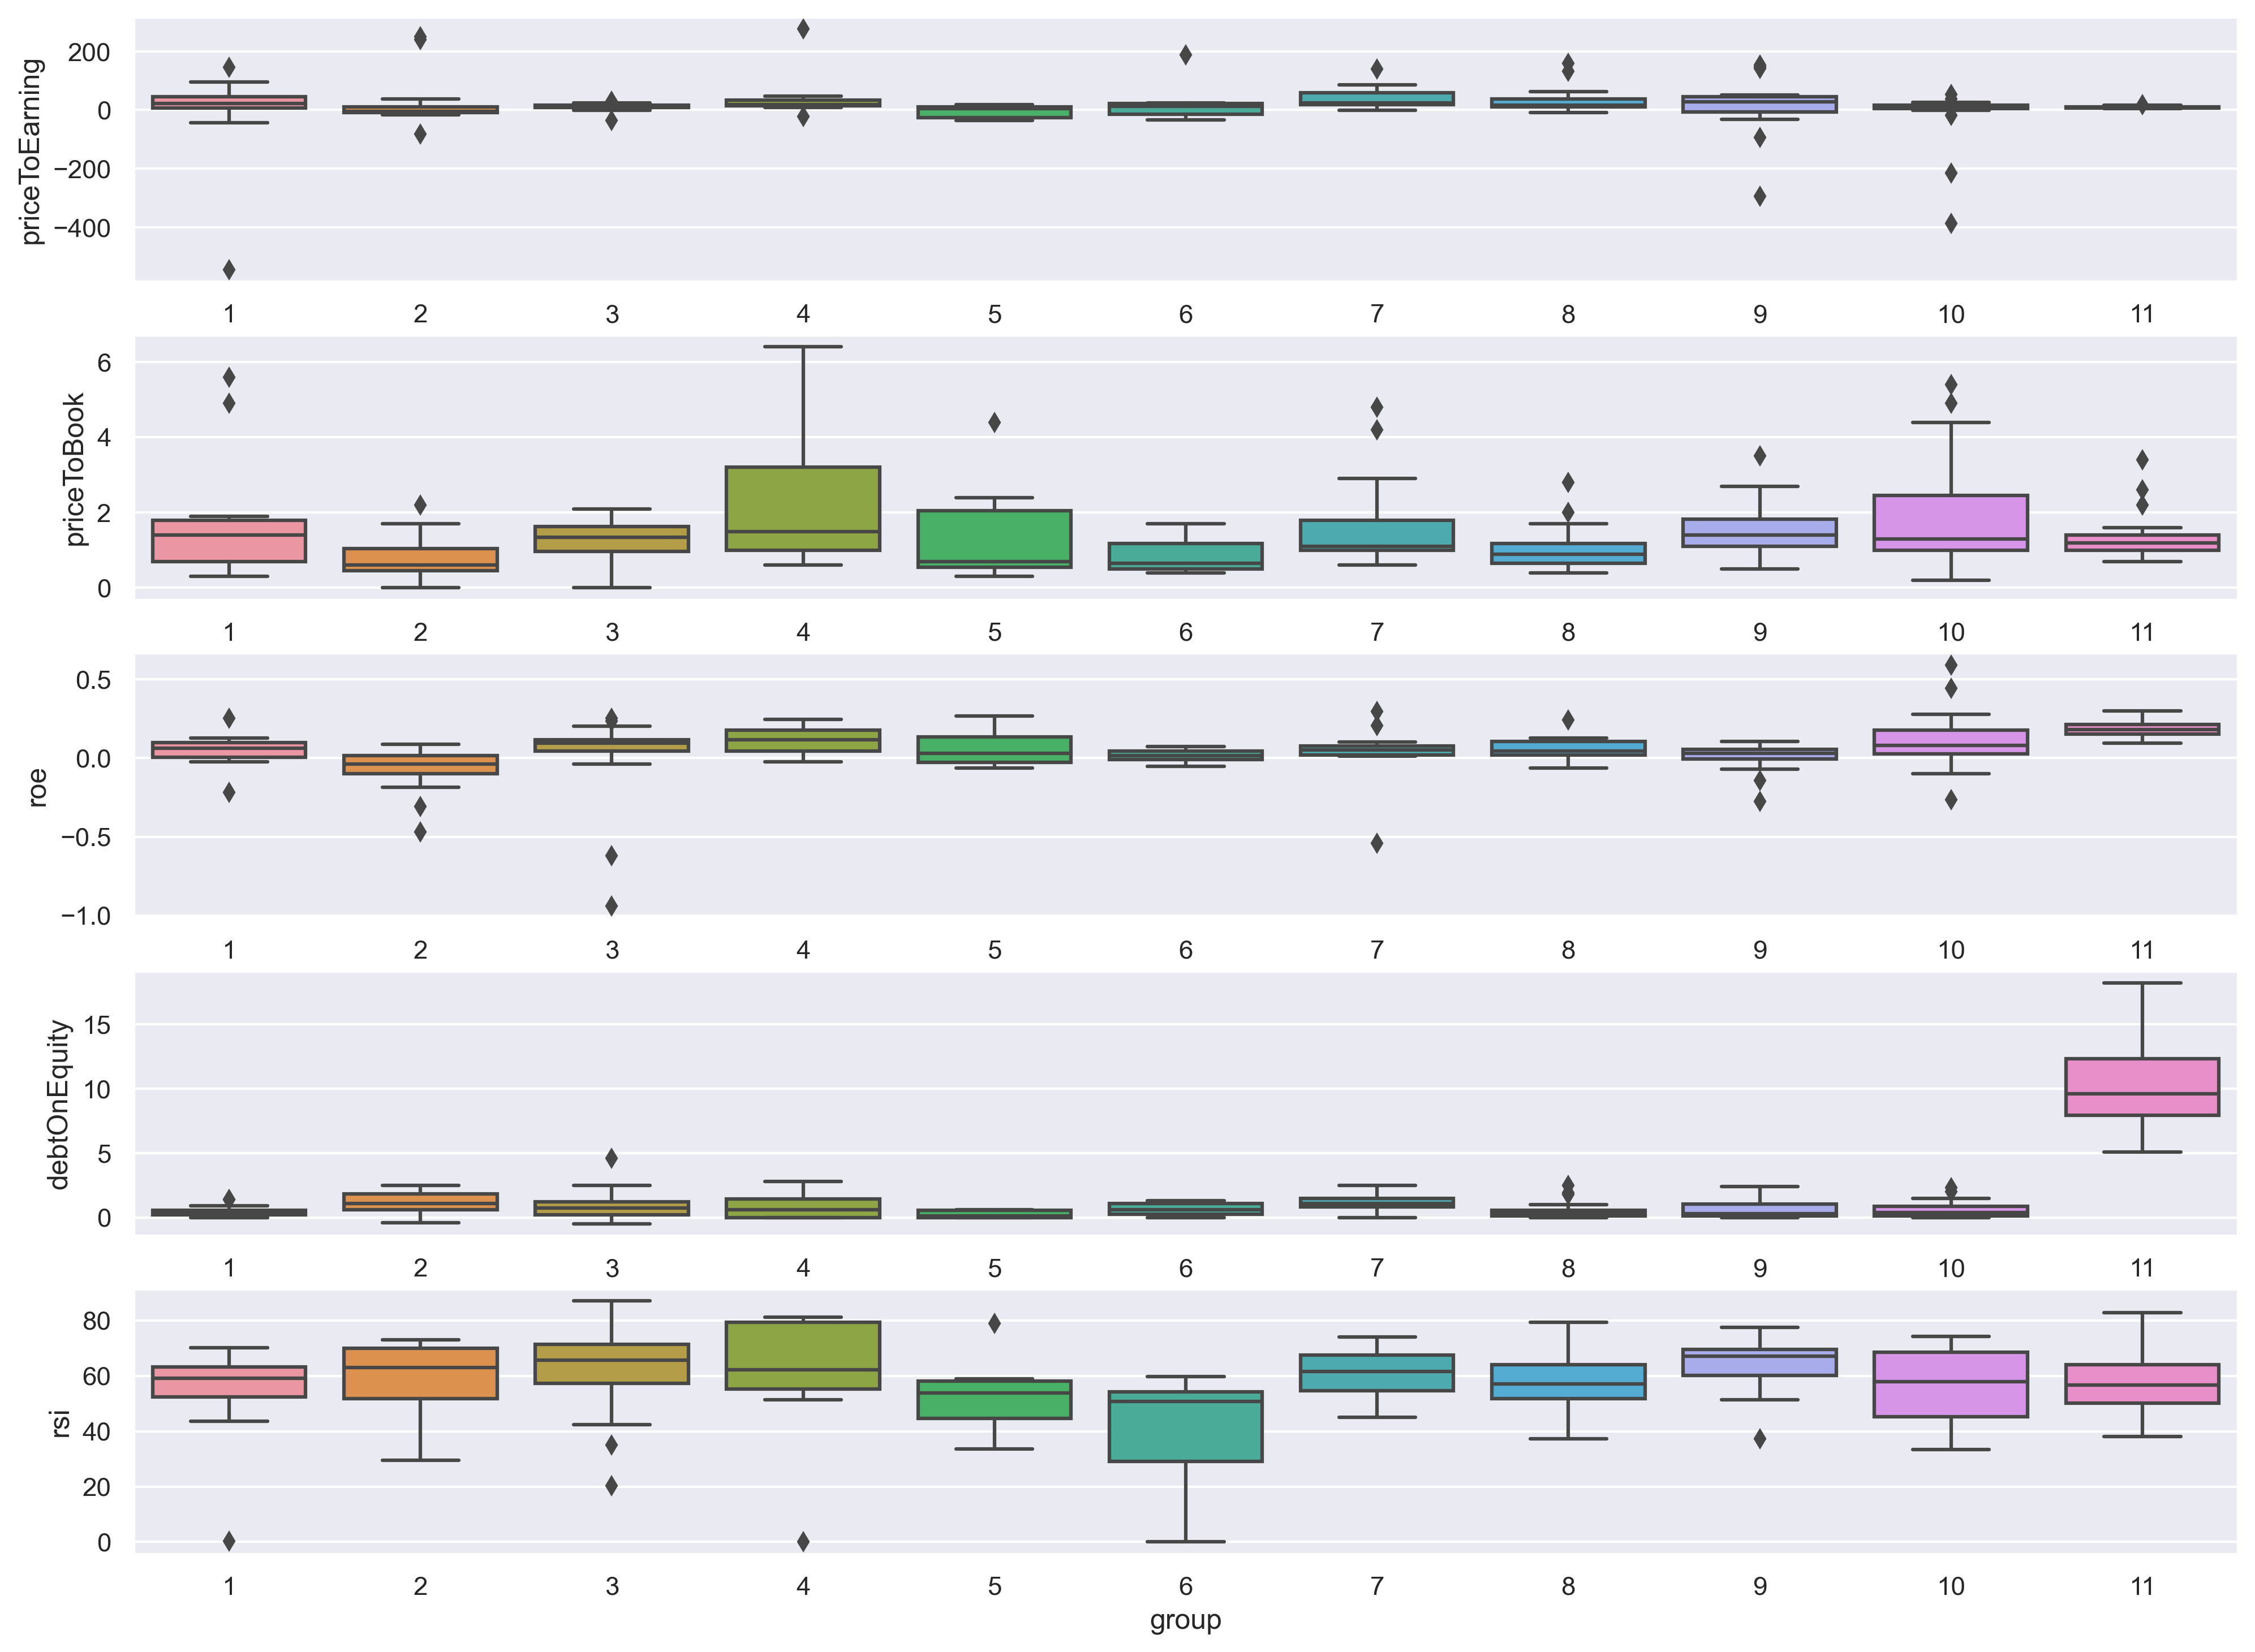

In [212]:

figs, axs = plt.subplots(nrows=5,figsize = (16,12))
for id,col in enumerate(["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]):
  ax = sns.boxplot(x = "group",y=col, data = df,ax = axs[id])

According to the boxplot above, variance of each group is homogeneous, assuming the sampled population is normal distributed, we can apply anova f-test and then anom.
*Note: the normality assumption may not satisfied but the result can be acceptable, for better result, we also used ranking but not in this file.

In [213]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(*lis_group)
print(fvalue, pvalue)

[ 0.97826886  2.72126721  3.73986939 89.9212573   2.05100127] [4.64244228e-01 3.99270113e-03 1.48003851e-04 2.61348400e-62
 3.11124452e-02]


As you can see that the f values is pretty large and p values of 2,4,5th attribute is verry close to 0, this tells us there is significant different between our groups.

Now we apply ANOM to find which group is different from others

In [214]:
from scipy.stats import t
def ANOM(args, alpha = 0.05):
    if not (0 < alpha < 1):
        raise ValueError("alpha can only get values between 0 - 1")

    k = len(args)
    mean_var = np.sum([np.var(group,axis =0) for group in args],axis = 0)/(k)
    
    N = sum(len(i) for i in args)
    
    a2 = 1 - (1-alpha)**(1/k)
    df = N - k
    grand = np.mean(np.concatenate((args),axis =0),axis =0)

    result = []
    for group in args:
        ni = len(group)
        h = abs(t.ppf(q = a2/2, df = df))
        UDL = grand + np.sqrt(mean_var)*h*np.sqrt((N-ni)/(N*ni))
        LDL = grand - np.sqrt(mean_var)*h*np.sqrt((N-ni)/(N*ni))
        result.append([UDL,LDL])
        
    return grand,result
    

The calculation and methods we used is described in our paper.

In [215]:
grand_mean, DL = ANOM([np.atleast_2d(g) for g in lis_group])

In [216]:
grand_mean

array([1.53994444e+01, 1.44166667e+00, 5.36944444e-02, 1.80555556e+00,
       5.85783333e+01])

Finally we plot to see the result

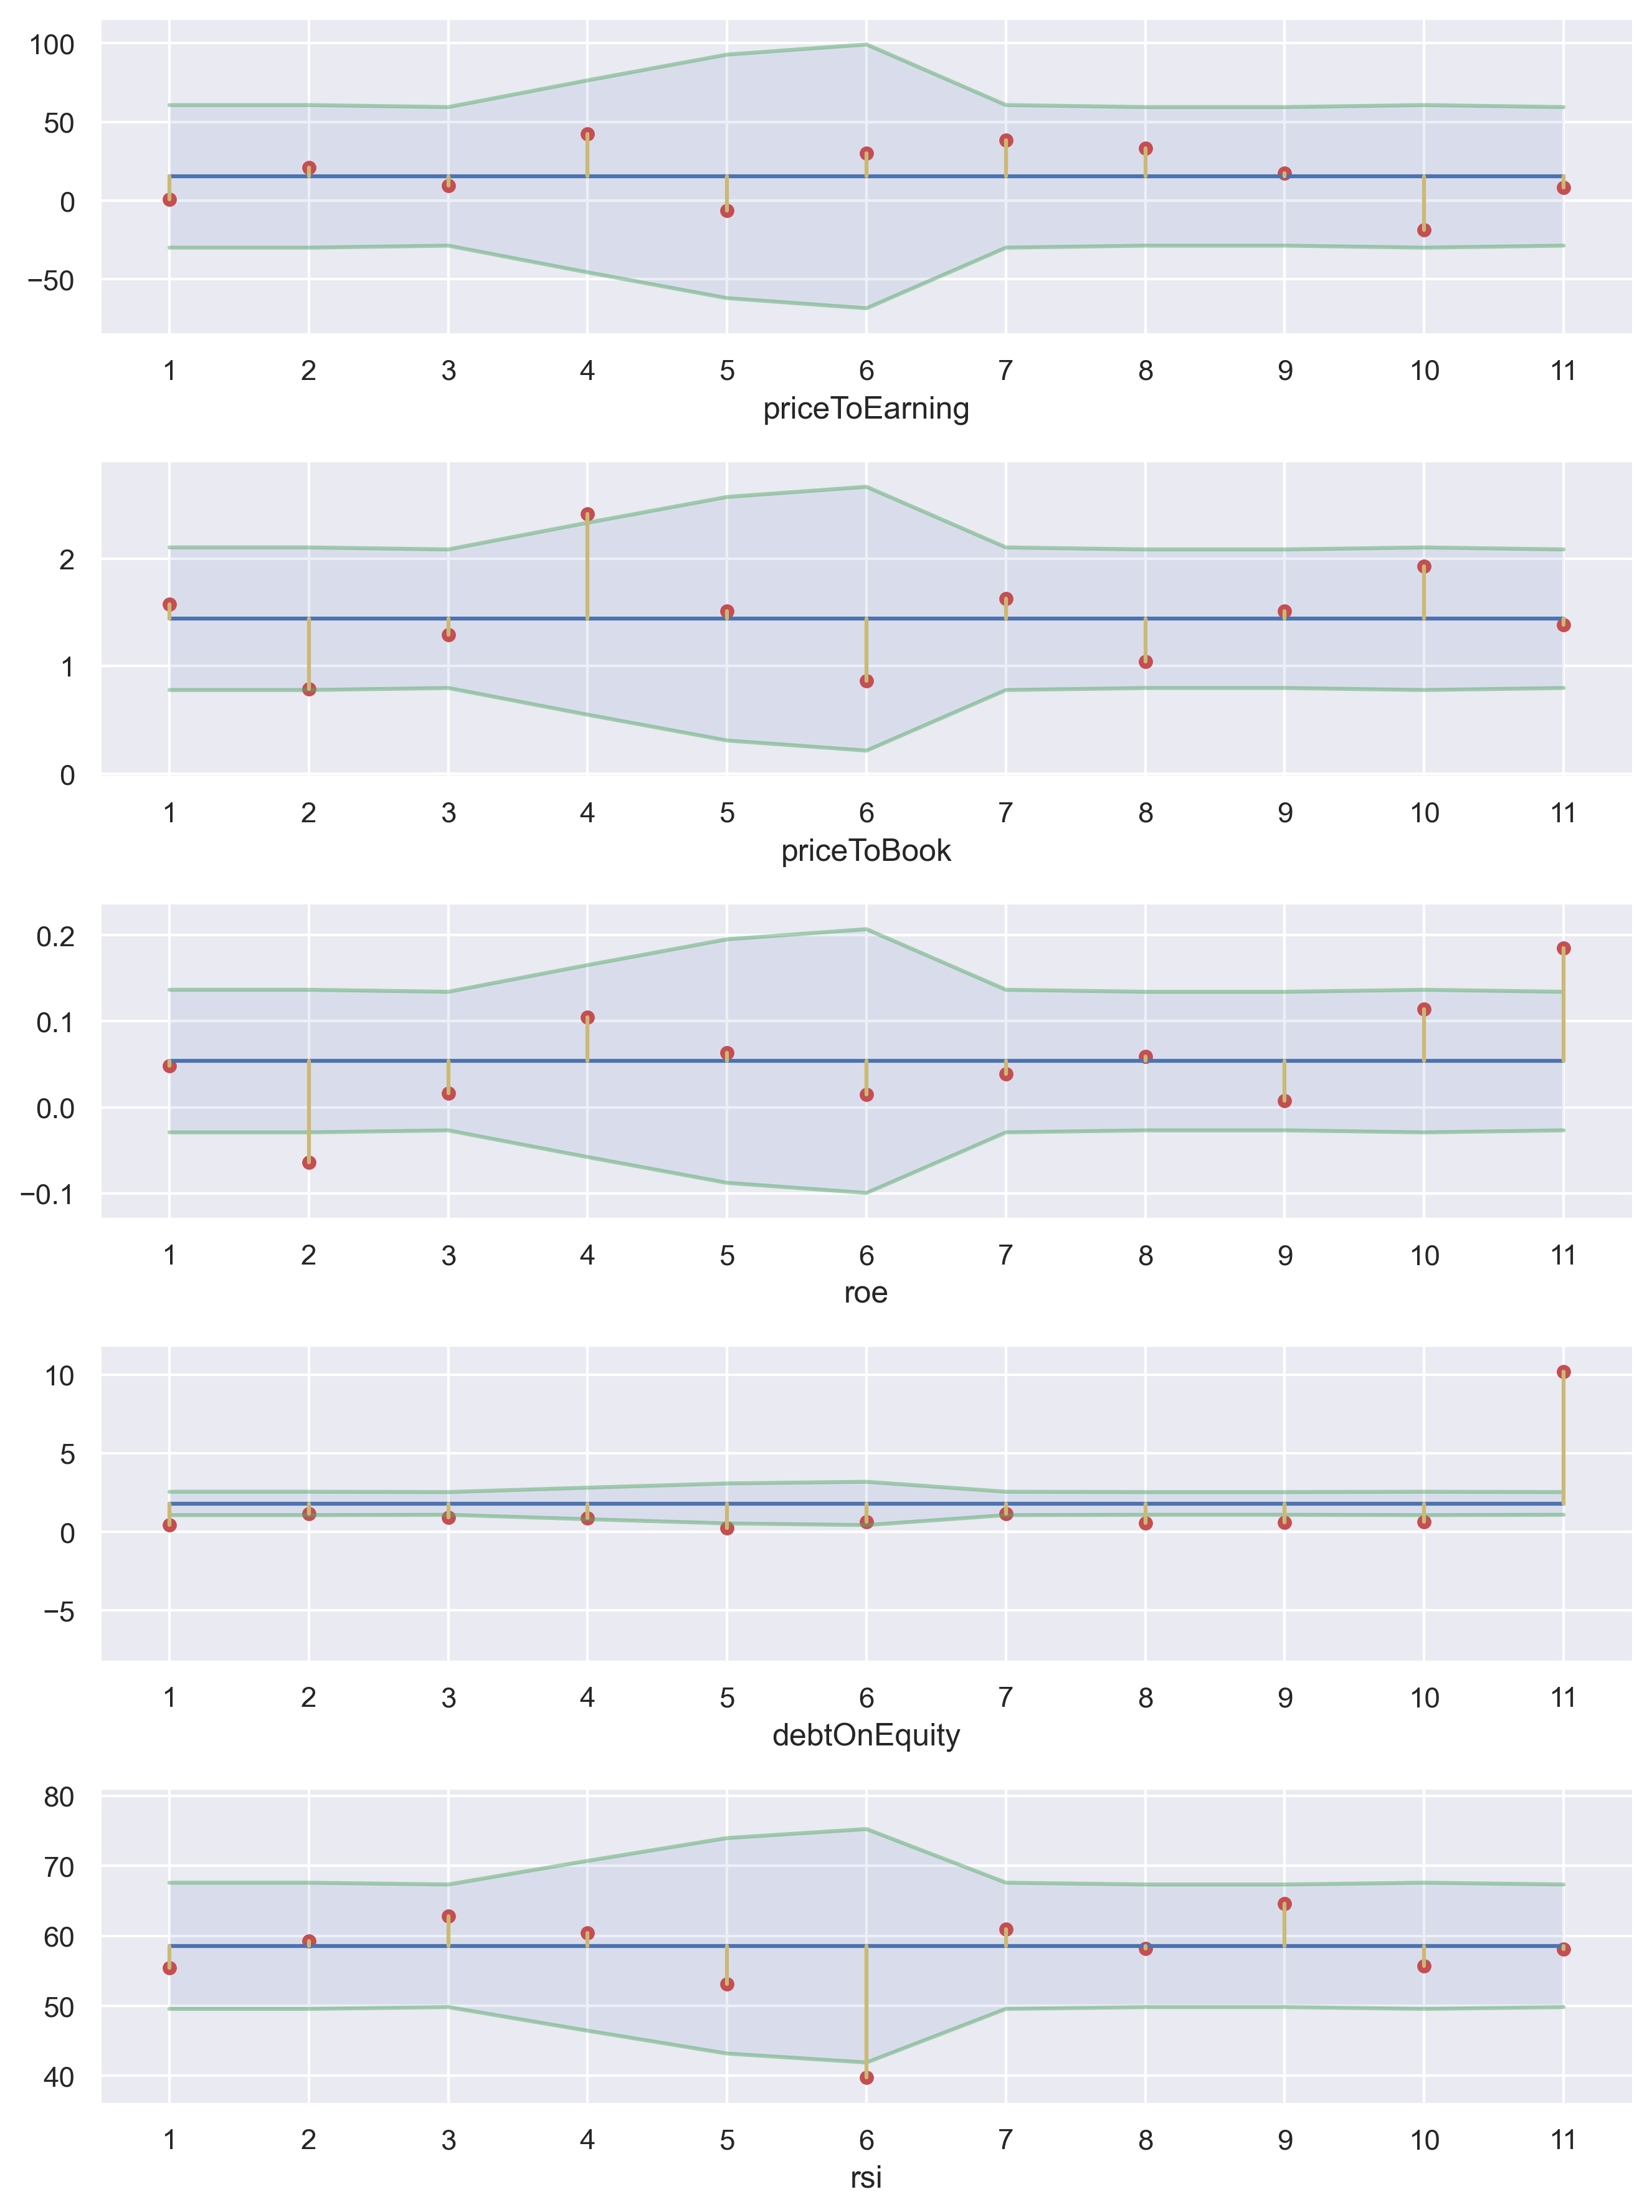

In [217]:
att_name = ["priceToEarning", "priceToBook","roe","debtOnEquity" ,"rsi"]
x = np.linspace(1,number_group,1000)
figs, axs = plt.subplots(nrows=5,figsize = (9,12))
for i in range(len(np.atleast_1d(lis_group[0])[0])):
  axs[i].plot(x,0*x + grand_mean[i])
  x = np.arange(1,1+len(lis_group))
  axs[i].plot(x, [DL[j][0][i] for j in range(len(DL))],'g',alpha = .5)
  axs[i].plot(x, [DL[j][1][i] for j in range(len(DL))],'g',alpha = .5)
  axs[i].fill_between(x,[DL[j][0][i] for j in range(len(DL))],[DL[j][1][i] for j in range(len(DL))],alpha=0.1)
  axs[i].scatter(x, [lis_group[j].mean()[i] for j in range(len(DL))],20,'r')
  tol = max(max(np.abs(-grand_mean[i]+[lis_group[j].mean()[i] for j in range(len(DL))]))*1.2, max([DL[k][0][i]-grand_mean[i] for k in range(len(DL))])*1.2)
  axs[i].set_ylim(grand_mean[i]-tol,grand_mean[i]+tol)
  axs[i].set_xticks(range(1,len(DL)+1))
  axs[i].set_xlabel(att_name[i])
  for j in range(1, len(DL)+1):
    axs[i].plot([j,j],[grand_mean[i],lis_group[j-1].mean()[i]],c = 'y')

figs.tight_layout()


In [218]:
group_dict

{1: 'real_estate',
 2: 'mineral',
 3: 'production',
 4: 'retail',
 5: 'Technology',
 6: 'tourism',
 7: 'transportation',
 8: 'chemistry',
 9: 'security',
 10: 'Drink_food',
 11: 'Bank_ind'}

Further analysis and conclusion is in our report. We also write code for anom-r using rank as a transformation method to compare with this result.